In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import nltk
import random
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LinearRegression


In [2]:
df = pd.read_csv("tolabel.csv", sep="|")
df = df[["Manuscript no.", "Reviewer ID", "CleanedComments", "Rec", "Suitable", "ShouldBe", "HumanLabel"]]
df = df.set_index(["Manuscript no."])
scored_bert = pd.read_csv("metascience/PeerRead/bert_output_20191104/eval_results_full_allelife.txt", 
                          sep="\t", names=["id", "score", "dummy", "text"])

list(scored_bert.sort_values(by="score", ascending=False).iloc[1:10,]["text"])
df["score"] = list(scored_bert.score)
df["Text"] = list(scored_bert.text)

In [3]:
df

,Reviewer ID,CleanedComments,Rec,Suitable,ShouldBe,HumanLabel,score,Text
Manuscript no.,,,,,,,,
8928,35261.0,The manuscript by Akiyama et al. addresses an ...,True,True,False,3.0,3.541255,The manuscript by Akiyama et al. addresses an ...
2978,10758.0,The centromere and kinetochore are required fo...,True,False,True,3.0,3.445980,The centromere and kinetochore are required fo...
40262,118410.0,This is a terrific paper that should be publis...,True,False,True,3.0,3.628239,This is a terrific paper that should be publis...
40670,15935.0,This manuscript presents biochemical evidence ...,True,False,True,3.0,2.923506,This manuscript presents biochemical evidence ...
48,9800.0,This manuscript addresses the mechanism of the...,True,False,False,3.0,3.597114,This manuscript addresses the mechanism of the...
68,1720.0,One of the surprising and exciting development...,True,False,False,3.0,3.530494,One of the surprising and exciting development...
109,47531.0,This paper describes a very interesting study...,True,False,False,3.0,3.421656,This paper describes a very interesting study ...
117,1049.0,Previous work from the Amon laboratory showed ...,True,False,False,3.0,3.235918,Previous work from the Amon laboratory showed ...
229,2152.0,The authors propse that the SNAP-25 mRNA is a ...,True,False,False,1.0,0.683601,The authors propse that the SNAP-25 mRNA is a ...


In [4]:
reviewers = pd.read_csv("gender_reviewers.csv", error_bad_lines=False)
# this is wrong
reviewers_data = pd.DataFrame(reviewers.groupby("Reviewer ID")["Reviewer name"].count())
reviewers_data.columns = ["reviewer_count"]

In [5]:
reviewers["review_count"] = reviewers.groupby("Reviewer ID")["gender"].transform("count")

In [6]:
reviewers

,Unnamed: 0,Manuscript no.,Reviewer no.,Reviewer ID,Reviewer name,Reviewer email,Reviewer institution,gender,review_count
0,0,1,1,1141,Gil McVean,mcvean@stats.ox.ac.uk,Oxford University,male,25
1,1,1,2,108710,Johannes Krause,krause@shh.mpg.de,Max Planck Institute for the Science of Human ...,male,1
2,2,1,3,2924,Garrett Hellenthal,g.hellenthal@ucl.ac.uk,UCL,male,2
3,3,2,1,1151,Jodi Nunnari,jmnunnari@ucdavis.edu,"University of California, Davis",female,11
4,4,2,2,1242,Eric Shoubridge,eric@ericpc.mni.mcgill.ca,McGill University,male,5
5,5,2,3,35496,Leo J Pallanck,pallanck@u.washington.edu,University of Washington,male,5
6,6,3,1,1123,Roberto Kolter,roberto_kolter@hms.harvard.edu,Harvard Medical School,male,17
7,7,3,2,1348,Bruno Lema&#x00EE;tre,bruno.lemaitre@epfl.ch,&#x00C9;cole Polytechnique F&#x00E9;d&#x00E9;r...,male,14
8,8,5,1,1189,Kevin Struhl,kevin@hms.harvard.edu,Harvard Medical School,male,31
9,9,5,2,1385,Patrick Schultz,Patrick.Schultz@igbmc.fr,INSERM University of Strasbourg,male,1


In [9]:
domain = []
for i in reviewers["Reviewer email"].str.split("."):
    try:
        domain += [i[-1]]
    except TypeError:
        domain += [""]
reviewers["domain"] = domain

In [10]:
# read in paper history stuff
e = pd.read_csv("/share/pi/dmcfarla/eLifeRawData/DM_Data_Reviews/DM_Data/eLife_Paper_history_2019_03_15.csv")
e["Manuscript no."] = e["ms"]
e = e.set_index(["Manuscript no."])
e = e.dropna(subset=["full_decision"])

# to get finaldecision, take last non-NA decision of the ones listed here
# note that this excludes rejected by initial decision
e["FinalDecision"] = e.apply(lambda x: list(x[["full_decision", "rev1_decision", "rev2_decision", "rev3_decision", "rev4_decision"]].dropna())[-1], axis=1)
e["outcome"] = np.where(e["FinalDecision"] == "Accept Full Submission", 1, 0)


/share/sw/open/anaconda/3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (20,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
reviewers

,Unnamed: 0,Manuscript no.,Reviewer no.,Reviewer ID,Reviewer name,Reviewer email,Reviewer institution,gender,review_count,domain
0,0,1,1,1141,Gil McVean,mcvean@stats.ox.ac.uk,Oxford University,male,25,uk
1,1,1,2,108710,Johannes Krause,krause@shh.mpg.de,Max Planck Institute for the Science of Human ...,male,1,de
2,2,1,3,2924,Garrett Hellenthal,g.hellenthal@ucl.ac.uk,UCL,male,2,uk
3,3,2,1,1151,Jodi Nunnari,jmnunnari@ucdavis.edu,"University of California, Davis",female,11,edu
4,4,2,2,1242,Eric Shoubridge,eric@ericpc.mni.mcgill.ca,McGill University,male,5,ca
5,5,2,3,35496,Leo J Pallanck,pallanck@u.washington.edu,University of Washington,male,5,edu
6,6,3,1,1123,Roberto Kolter,roberto_kolter@hms.harvard.edu,Harvard Medical School,male,17,edu
7,7,3,2,1348,Bruno Lema&#x00EE;tre,bruno.lemaitre@epfl.ch,&#x00C9;cole Polytechnique F&#x00E9;d&#x00E9;r...,male,14,ch
8,8,5,1,1189,Kevin Struhl,kevin@hms.harvard.edu,Harvard Medical School,male,31,edu
9,9,5,2,1385,Patrick Schultz,Patrick.Schultz@igbmc.fr,INSERM University of Strasbourg,male,1,fr


In [12]:
df_e = df.join(e)
#df_e = df_e.set_index(["ms"])
#df_e = df.reset_index()
#df_e = df_e.merge(reviewers, on=["Reviewer ID"])
#df_e = df_e.set_index(df_e["Manuscript no."])

In [13]:
df_e.groupby(["outcome"]).mean()["score"]

outcome
0.0    1.908838
1.0    2.618359
Name: score, dtype: float64

In [14]:
countries = pd.DataFrame(df_e.groupby(["country"]).count()["Rec"])
countries["mean_score"] = df_e.groupby(["country"]).mean()["score"]
countries["mean_outcome"] = df_e.groupby(["country"]).mean()["outcome"]

In [15]:
countries.loc[countries["Rec"] > 300, "mean_score"].sort_values()

country
China             2.096820
Japan             2.126028
Spain             2.141209
Israel            2.155541
Netherlands       2.181371
Italy             2.189906
Australia         2.225614
France            2.238966
Switzerland       2.265046
Canada            2.279189
United Kingdom    2.294331
Germany           2.301249
United States     2.351139
Name: mean_score, dtype: float64

In [19]:
countries.loc[countries["Rec"] > 300, "mean_outcome"].sort_values()

country
Israel            0.374713
Italy             0.375000
China             0.408624
Spain             0.427350
Japan             0.446575
Netherlands       0.469734
France            0.494068
Canada            0.494705
Australia         0.518610
Germany           0.527219
United Kingdom    0.533219
Switzerland       0.562500
United States     0.578999
Name: mean_outcome, dtype: float64

3.0    382
1.0    237
4.0    178
2.0    110
Name: HumanLabel, dtype: int64

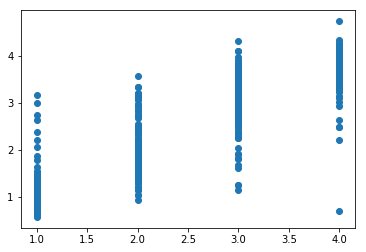

In [21]:
labeled = df.loc[~pd.isna(df.HumanLabel)]
labeled = labeled.loc[labeled.HumanLabel <= 5]
labeled[["score", "HumanLabel"]].corr()

%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(labeled.HumanLabel, labeled.score)
labeled.HumanLabel.value_counts()

(array([164.,  73.,  43.,  44.,  30.,  87., 248., 153.,  63.,   2.]),
 array([0.573622 , 0.9896458, 1.4056696, 1.8216934, 2.2377172, 2.653741 ,
        3.0697648, 3.4857886, 3.9018124, 4.3178362, 4.73386  ]),
 <a list of 10 Patch objects>)

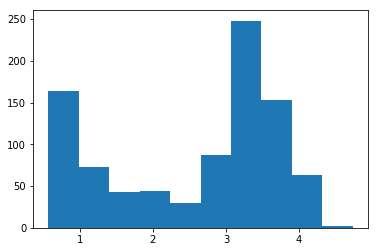

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(labeled.score)

(array([237.,   0.,   0., 110.,   0.,   0., 382.,   0.,   0., 178.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <a list of 10 Patch objects>)

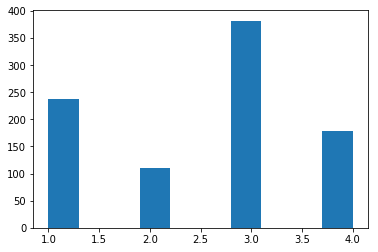

In [25]:
plt.hist(labeled.HumanLabel)

In [26]:
df_e["review_outcome"] = "none"

In [27]:
df_e["zscore"] = (df_e.score - np.mean(df_e.score))/np.std(df_e.score)

In [28]:
df_e.loc[(df_e.zscore > 1) & (df_e.outcome == 1), "review_outcome" ] = "pos_pos"
df_e.loc[(df_e.zscore > 1) & (df_e.outcome == 0), "review_outcome" ] = "pos_neg"
df_e.loc[(df_e.zscore < -1) & (df_e.outcome == 0), "review_outcome" ] = "neg_neg"
df_e.loc[(df_e.zscore < -1) & (df_e.outcome == 1), "review_outcome" ] = "neg_pos"


In [29]:
df_e.review_outcome.value_counts()

none       15398
neg_neg     4390
pos_pos     4373
neg_pos     1545
pos_neg     1139
Name: review_outcome, dtype: int64

In [32]:
# papers with disagreement
disagreement = df_e.loc[(df_e.review_outcome == "pos_neg") | (df_e.review_outcome == "neg_pos")]

In [33]:
disagreement_papers = df_e.loc[set(disagreement.index)]

In [37]:
def get_example_disagreement():
    ex = disagreement_papers.loc[random.choice(disagreement_papers.index)]
    ex = (ex[["CleanedComments", "score", "outcome"]])
    print("outcome:", list(ex["outcome"])[0])
    for i in range(ex.shape[0]):
        print(ex.iloc[i]["score"], ex.iloc[i]["CleanedComments"] + "\n")
    
get_example_disagreement()    

outcome: 1.0
1.0315402 The manuscript by Rao and colleagues analyzes the functions of Tet2 and Tet3, which oxidize 5-methyl cytosine and promote DNA demethylation, in a specific developmental and context, namely the generation of B cells. The significance of the work lies in the attempt to elucidate molecular actions of these enzymes in the control of chromatin accessibility at developmentally important genomic regions. In this instance the authors focus much of their analysis on enhancers in the immunoglobulin kappa light chain locus which have been shown previously to control germline transcription (transcription that precedes DNA rearrangement) as well as somatic DNA rearrangement of the locus during B cell development.Using a germline Tet2 KO allele and a conditional Tet3 allele which is deleted using Mb1Cre (DKO) they demonstrate that loss of both Tet2 and Tet3 results in a block to B cell development, albeit one that is more pronounced in older mice (8 versus 12 weeks of age). Th

In [38]:
disagreement_papers["winner"] = np.where(list((disagreement_papers.review_outcome == "neg_neg") | (disagreement_papers.review_outcome == "pos_pos")), "winner", "none")
disagreement_papers["winner"] = np.where(list((disagreement_papers.review_outcome == "neg_pos") | (disagreement_papers.review_outcome == "pos_neg")), "loser", disagreement_papers.winner)

/share/sw/open/anaconda/3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/share/sw/open/anaconda/3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [39]:
disagreement_papers.review_outcome.value_counts()

none       2799
neg_pos    1545
pos_neg    1139
pos_pos     836
neg_neg     702
Name: review_outcome, dtype: int64

In [40]:
disagreement_papers["length_text"] = (disagreement_papers["CleanedComments"].str.len())

/share/sw/open/anaconda/3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [41]:
disagreement_papers.groupby("winner").mean()["length_text"]

winner
loser     2933.900894
none      3235.063951
winner    2802.697659
Name: length_text, dtype: float64

In [42]:
winners_losers = disagreement_papers.loc[(disagreement_papers.winner == "winner") | (disagreement_papers.winner == "loser")]

In [43]:
# make a classifier that predicts outcome based on review
x = winners_losers
x.initial_qc_dt = pd.to_datetime(x.initial_qc_dt)
train = x[pd.to_datetime(x.initial_qc_dt) <= pd.to_datetime("2017-06-30")]
test = x[((x.initial_qc_dt > pd.to_datetime("2017-06-30")) & (x.initial_qc_dt < pd.to_datetime("2018-01-01")))]
word_vectorizer = CountVectorizer(analyzer='word')
tags = [i == "winner" for i in train["winner"]]
test_tags = [i == "winner" for i in test["winner"]]

vectorizer = TfidfVectorizer(min_df=20, max_df=0.8, ngram_range=(1, 2),
                             stop_words=stopwords.words('english'))
processed_features = vectorizer.fit_transform(list(train["CleanedComments"]))
test_processed_features = vectorizer.transform(list(test["CleanedComments"]))

text_classifier = LogisticRegression()
text_classifier.fit(processed_features, tags)
predictions = text_classifier.predict(processed_features)

# in-sample
np.mean(predictions == tags)



/share/sw/open/anaconda/3/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/share/sw/open/anaconda/3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7500866551126516

In [44]:
# print top10 features, bottom10
def print_top10(vectorizer, clf):
    feature_names = vectorizer.get_feature_names()
    print ("top 10")
    for j in reversed(np.argsort(clf.coef_[0])[-10:]):
        print (feature_names[j])
    print ("\nbottom 10")
    for j in np.argsort(clf.coef_[0])[0:10]:
        print (feature_names[j])

print_top10(vectorizer, text_classifier)        

top 10
first
substrate
transgenic
provides
broad
compelling
step
well
mtor
functions

bottom 10
however
questions
figure
association
expert
may
example
whether
assay
studies


In [36]:
disagreement_papers.columns

Index(['Reviewer ID', 'CleanedComments', 'Rec', 'Suitable', 'ShouldBe',
       'HumanLabel', 'score', 'Text', 'ms', 'type', 'country', 'senior_editor',
       'initial_qc_dt', 'initial_decision', 'initial_decision_dt',
       'reviewing_editor', 'full_qc_dt', 'full_decision', 'full_decision_dt',
       'rev1_qc_dt', 'rev1_decision', 'rev1_decision_dt', 'rev2_qc_dt',
       'rev2_decision', 'rev2_decision_dt', 'rev3_qc_dt', 'rev3_decision',
       'rev3_decision_dt', 'rev4_qc_dt', 'rev4_decision', 'rev4_decision_dt',
       'p.poa_dt', 'p.vor_dt', 'FinalDecision', 'outcome', 'review_outcome',
       'zscore', 'winner', 'length_text'],
      dtype='object')

In [61]:
review_dis = disagreement_papers.reset_index().merge(reviewers, on=["Manuscript no.", "Reviewer ID"])

In [62]:
review_dis.groupby("winner").mean()["review_count"]

winner
loser     7.253318
none      7.831088
winner    8.205902
Name: review_count, dtype: float64

In [63]:
review_dis["gender_binary"] = review_dis["gender"].str.contains("female")

In [64]:
review_dis.groupby("winner").mean()["gender_binary"]

winner
loser     0.209329
none      0.196942
winner    0.196066
Name: gender_binary, dtype: float64

In [75]:
review_dis.gender_binary.mean()

0.20147633521493705

In [111]:
c = review_dis.groupby(["domain", "winner"]).count()["Manuscript no."]
sums = c.groupby(level=0).sum().reset_index()
keepers = sums.loc[sums["Manuscript no."] > 100]["domain"]
c = c.loc[keepers]
sums = c.groupby(level=0).sum()
review_domain_winners = c/sums
review_domain_winners = review_domain_winners.reset_index()
review_domain_winners.loc[review_domain_winners.winner == "winner"].sort_values("Manuscript no.")

,domain,winner,Manuscript no.
8,com,winner,0.172549
23,jp,winner,0.190909
20,gov,winner,0.205128
29,uk,winner,0.206471
5,ch,winner,0.227273
2,ca,winner,0.228311
14,edu,winner,0.229564
26,org,winner,0.242331
11,de,winner,0.246377
17,fr,winner,0.253521
